## Carregando as bibliotecas e os dados

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.api import ARIMA, SARIMAX
from scipy.stats import norm

In [2]:
# Carregando e ajustando os dados
data = pd.read_csv("data.csv")
data["week"] = pd.to_datetime(data["week"])
data_series = data.set_index("week")["volume"]

print(data_series.head())

week
2022-10-31    0.33
2022-11-07    0.47
2022-11-14    0.32
2022-11-21    1.69
2022-11-28    1.23
Name: volume, dtype: float64


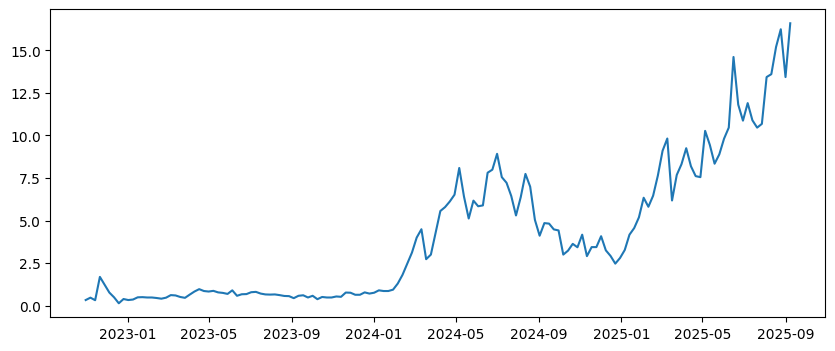

In [3]:
# Exibindo os dados
plt.figure(figsize = (10, 4))
plt.plot(data_series)
plt.show()

## Avaliando a decomposição da série em tendência e sazonalidade

Primeiramente, vamos avaliar a existência de padrões de tendência e de sazonalidade nessa série de dados. Para isso, calculamos suas autocorrelações, que estão exibidas abaixo.

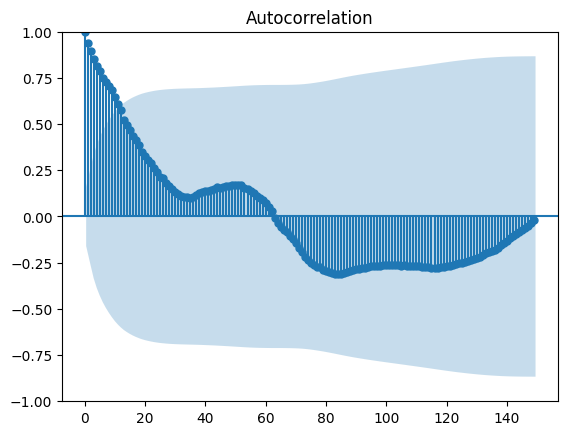

In [4]:
# Calculando e exibindo a função de autocorrelação
plot_acf(data_series, lags = 149)
plt.show()

Analisando o gráfico, podemos concluir que há um forte indício da existência de tendência nesse conjunto de dados, o que pode ser constatado pela alta correlação entre valores temporalmente próximos que diminui lentamente até valores maiores de lag. Por outro lado, não há sinal de sazonalidade, já que não existem picos significativos de autocorrelação além do presente em lags menores.

Isso pode ser mais profundamente testado por meio da efetiva decomposição desse dado nas três componentes temporais (tendência, sazonalidade e resíduo) e da observação do comportamento dos resíduos resultantes. Nos gráficos abaixo, realizamos a decomposição com janelas temporais de 4 semanas (ciclo mensal) e de 52 semanas (ciclo anual).

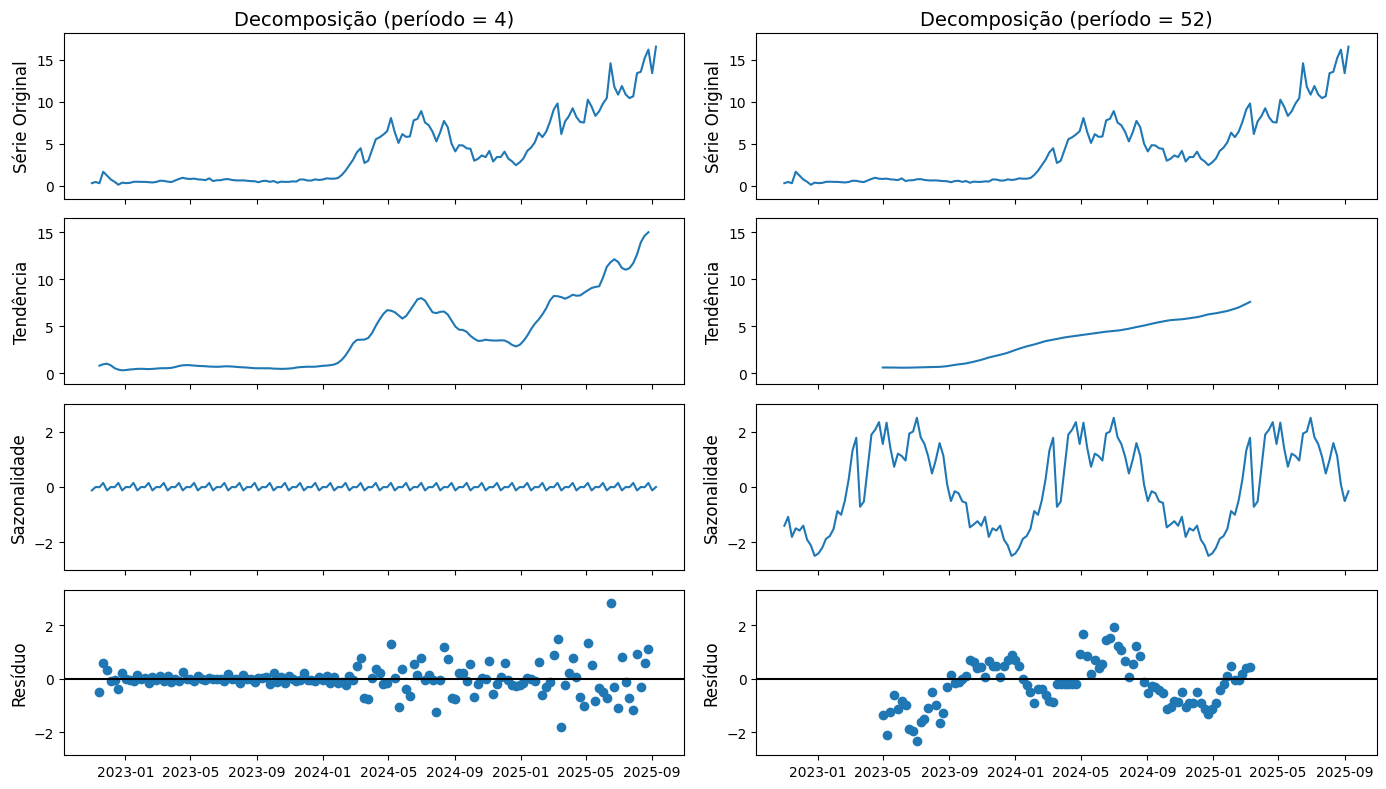

In [5]:
# Fazendo a decomposição da série nas duas janelas de interesse
decomposition_4_weeks = seasonal_decompose(data_series, model = "additive", period = 4)
decomposition_52_weeks = seasonal_decompose(data_series, model = "additive", period = 52)

fig, axes = plt.subplots(4, 2, figsize=(14, 8), sharex=True)

components_4 = [decomposition_4_weeks.observed,
                decomposition_4_weeks.trend,
                decomposition_4_weeks.seasonal,
                decomposition_4_weeks.resid]

components_52 = [decomposition_52_weeks.observed,
                 decomposition_52_weeks.trend,
                 decomposition_52_weeks.seasonal,
                 decomposition_52_weeks.resid]

min_data = min(data_series)
max_data = max(data_series)
min_trend = min(min(components_4[1].dropna()), min(components_52[1].dropna()))
max_trend = max(max(components_4[1].dropna()), max(components_52[1].dropna()))
min_seasonal = min(min(components_4[2].dropna()), min(components_52[2].dropna()))
max_seasonal = max(max(components_4[2].dropna()), max(components_52[2].dropna()))
min_residuals = min(min(components_4[3].dropna()), min(components_52[3].dropna()))
max_residuals = max(max(components_4[3].dropna()), max(components_52[3].dropna()))

titles = ['Série Original', 'Tendência', 'Sazonalidade', 'Resíduo']
lims = [(min_data, max_data), (min_trend, max_trend), (min_seasonal, max_seasonal), (min_residuals, max_residuals)]

for i in range(4):
    if i < 3:
        axes[i, 0].plot(components_4[i])
    else:
        axes[i, 0].scatter(data_series.index, components_4[i])
        axes[i, 0].axhline(0, color = "black")

    axes[i, 0].set_ylim((lims[i][0] - 0.1*(lims[i][1]-lims[i][0]), lims[i][1] + 0.1*(lims[i][1]-lims[i][0])))
    axes[i, 0].set_ylabel(titles[i], fontsize = 12)

for i in range(4):
    if i < 3:
        axes[i, 1].plot(components_52[i])
    else:
        axes[i, 1].scatter(data_series.index, components_52[i])
        axes[i, 1].axhline(0, color = "black")

    axes[i, 1].set_ylim((lims[i][0] - 0.1*(lims[i][1]-lims[i][0]), lims[i][1] + 0.1*(lims[i][1]-lims[i][0])))
    axes[i, 1].set_ylabel(titles[i], fontsize = 12) 
    
# 5. Adicione títulos específicos para as colunas e remova títulos individuais do subplot
axes[0, 0].set_title('Decomposição (período = 4)', fontsize = 14)
axes[0, 1].set_title('Decomposição (período = 52)', fontsize = 14)

# 6. Ajuste o layout
plt.tight_layout()
plt.show()

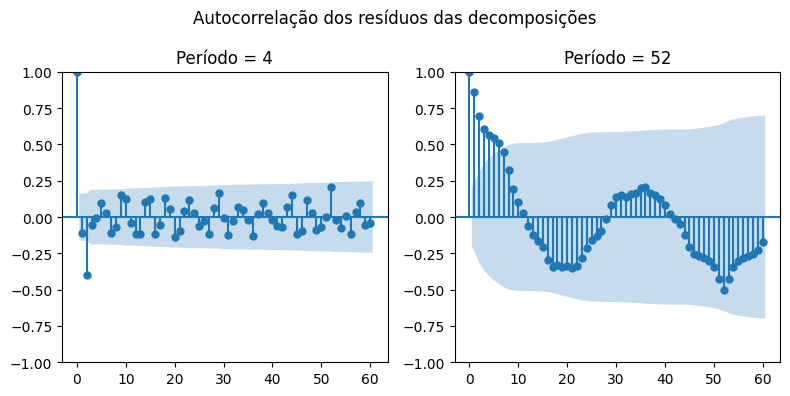

In [6]:
# Pegando os resíduos não nulos das decomposições e plotando suas ACFs
residuals_4_weeks = decomposition_4_weeks.resid.values
residuals_4_weeks = residuals_4_weeks[~np.isnan(residuals_4_weeks)]

residuals_52_weeks = decomposition_52_weeks.resid.values
residuals_52_weeks = residuals_52_weeks[~np.isnan(residuals_52_weeks)]

fig, axes = plt.subplots(1, 2, figsize = (8, 4))

plot_acf(residuals_4_weeks, ax = axes[0], lags = 60)
plot_acf(residuals_52_weeks, ax = axes[1], lags = 60)

fig.suptitle("Autocorrelação dos resíduos das decomposições")

axes[0].set_title("Período = 4")
axes[1].set_title("Período = 52")

plt.tight_layout()
plt.show()

Pode-se observar que, com um período de 4 semanas (1 mês), o valor absoluto da sazonalidade é muito baixo (entre -0.1 e 0.1), sendo pouco significativo para o dado como um todo. Além disso, seus resíduos são maiores ao final da série, indicando uma heterocedasticidade não desejável.

Já com relação ao período de 52 semanas (1 ano), apesar da componente sazonal ser mais significativa, os resíduos claramente apresentam correlação, não podendo ser caracterizados como ruído branco.

Portanto, em ambos os casos, vemos que não é adequada a decomposição da série utilizando uma componente sazonal.

## Selecionando o modelo a ser ajustado

Como foi inferida, na análise anterior, a existência de tendência mas a inexistência de sazonalidade no conjunto de dados em estudo, então, a seguir, analisaremos o ajuste de modelos da forma:

$$
f(\text{volume}_t) = \beta_0 + \beta_1 t + \epsilon_t
$$

onde $t$ corresponde à covariável de tendência do modelo e $f$ a uma possível transformação.

Ao observar o visual da série de dados, é possível perceber um padrão exponencial na variável de volume, o que sugere uma transformação logarítmica dos dados. Com isso em mente, vamos ajustar os seguintes dois modelos e analisar a qualidade de seus ajustes:

$$
\text{1. volume}_t = \beta_0 + \beta_1 t + \epsilon_t \\
\text{2. } \log(\text{volume}_t) = \beta_0 + \beta_1 t + \epsilon_t
$$

In [7]:
# Covariável t
time_covariate = np.arange(data_series.size)

# Criando os dados lineares e logarítmicos
X = sm.add_constant(time_covariate)
original_y = data_series
log_y = np.log(data_series)

# Ajustando os modelos
ols_model_linear = sm.OLS(original_y, X).fit()
ols_model_exponential = sm.OLS(log_y, X).fit()

In [8]:
print("R² ajustado:")
print("-> Modelo com y linear:     ", ols_model_linear.rsquared_adj)
print("-> Modelo com y logarítmico:", ols_model_exponential.rsquared_adj)

R² ajustado:
-> Modelo com y linear:      0.7205984579494695
-> Modelo com y logarítmico: 0.8141538995583324


Como observado, o modelo com a variável `volume` transformada por logaritmo apresentou um ajuste melhor e, portanto, será o modelo considerado para as próximas análises.

## Análise do ajuste do modelo

TODO: Escrever

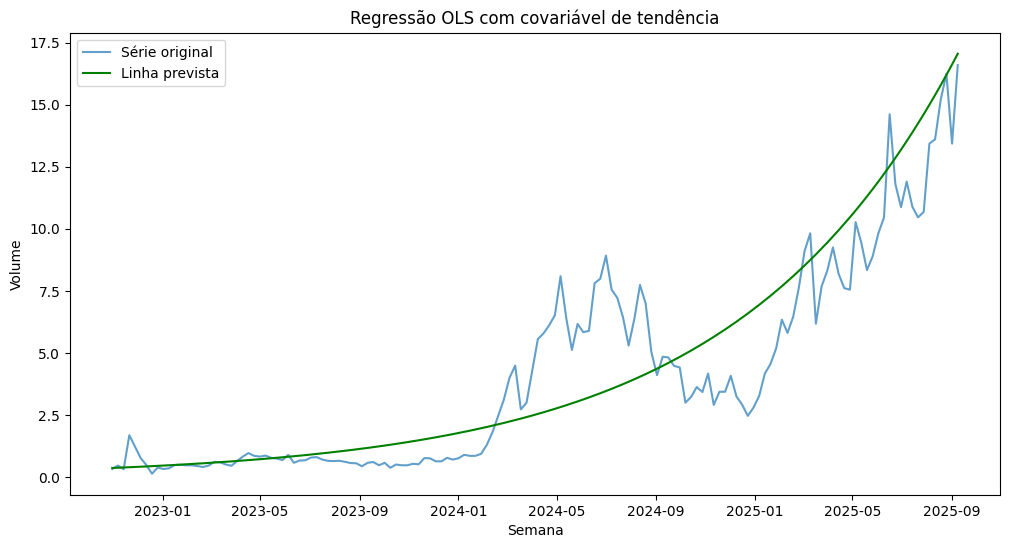

In [9]:
# Variância residual do ajuste
mse_resid = ols_model_exponential.mse_resid

# Fator de correção da transformação da predição para a escala original
correction_factor = np.exp(mse_resid / 2)

# Calculando a predição na escala original
predicted_original_scale_corrected = np.exp(ols_model_exponential.predict(X)) * correction_factor

plt.figure(figsize = (12, 6))
plt.plot(data_series.index, data_series, label = 'Série original', alpha = 0.7)
plt.plot(data_series.index, predicted_original_scale_corrected, color = 'green', linestyle = '-', label = 'Linha prevista')
plt.title('Regressão OLS com covariável de tendência')
plt.xlabel('Semana')
plt.ylabel('Volume')
plt.legend()
plt.show()

# Baselines
## Dividindo em treino e teste

In [10]:
ts_volume = data['volume']

percent_data = int((len(ts_volume)*0.2 ))
# Divisão cronológica dos dados
train = ts_volume.iloc[:-percent_data]
test = ts_volume.iloc[-percent_data:]

## Média
Começamos com o método mais ingênuo, o qual é estimar todos os outroso como a média do treino. 

In [11]:
predictions = {}

mean_forecast = np.mean(train)
predictions['Média'] = pd.Series(mean_forecast, index=test.index)

## Random Walk without Drift
O próximo método que temos é o Random Walk without drift, o qual consiste em simplesmente pegar o último valor e prever todos os próximos valores como ele.

In [12]:
random_naive_pred = train.iloc[-1]
predictions['Ingênuo'] = pd.Series(random_naive_pred, index=test.index)

## Random Walk with Drift
O método tende a prever o úlitmo valor, mas adiciona a tendência dos dados. Como por exemplo, se os dados tendem a ter uma queda no treino, o modelo vai decrescer essa taxa para as próximas previsões. Caso haja um crescimento o modelo acresce a taxa. 

In [13]:
T = len(train)
drift_value = (train.iloc[-1] - train.iloc[0]) / (T - 1)
h_steps = np.arange(1, len(test) + 1)
drift_forecast = train.iloc[-1] + h_steps * drift_value
predictions['Desvio (Drift)'] = pd.Series(drift_forecast, index=test.index)

## Método Ingênuo Sazonal
No método ingênuo sazonal, o que fazemos é assumir que há sazonalidade nos dados e apenas assumir que o próximo valor será o mésmo do último período que ele apareceu. como o modelo está em semanas, umas sazonalidade de 52 faz sentido. Podemos utilizar a classe sarimax do statsmodel que nós da essa previsão sem maiores esforços

In [14]:
m = 52
model_snaive = SARIMAX(train, order=(0, 0, 0), seasonal_order=(0, 1, 0, m))
fit_snaive = model_snaive.fit(disp=False)
predictions['Ingênuo Sazonal'] = fit_snaive.forecast(steps=len(test))

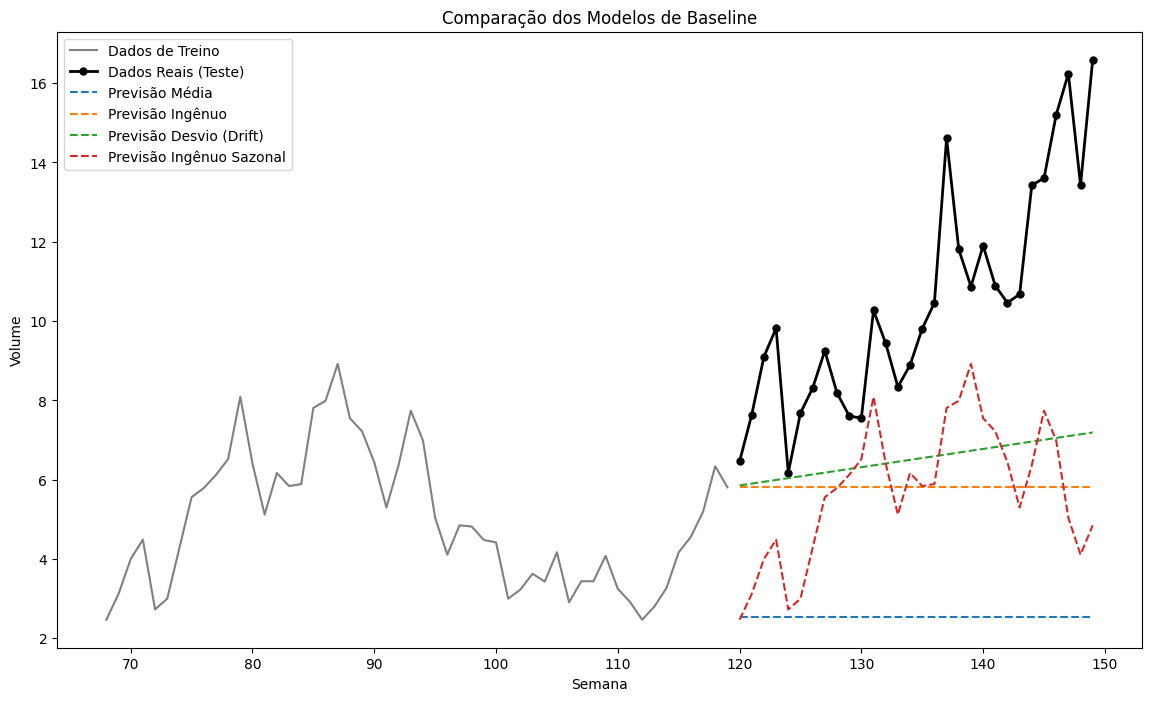

In [15]:
# 4. Avaliação e Visualização (Inalterado)
plt.figure(figsize=(14, 8))
plt.plot(train.iloc[-52:], label='Dados de Treino', color='gray')
plt.plot(test, label='Dados Reais (Teste)', color='black', linewidth=2, marker='o', markersize=5)

for name, forecast in predictions.items():
    plt.plot(forecast, label=f'Previsão {name}', linestyle='--')

plt.title('Comparação dos Modelos de Baseline')
plt.xlabel('Semana')
plt.ylabel('Volume')
plt.legend(loc='upper left')
plt.grid(False)
plt.show()

## Avaliando a previsão distribucional
Temos várias métricas para avaliar a previsão distribucional, tais quais:
winkler score, quantila score e Continuos ranked probability score (CRPS) (escrever mais sobre)

In [16]:
# Função para o Winkler Score
def winkler_score(y_true, lower, upper, alpha):
    score = np.where(
        y_true < lower,
        (upper - lower) + (2 / alpha) * (lower - y_true),
        np.where(
            y_true > upper,
            (upper - lower) + (2 / alpha) * (y_true - upper),
            (upper - lower)
        )
    )
    return np.mean(score)

# Função para o Erro de Quantil
def quantile_score(y_true, quantile_forecast, p):
    error = y_true - quantile_forecast
    return np.mean(np.where(error >= 0, p * error, (p - 1) * error))

# Função para o CRPS de uma distribuição Normal
def crps_gaussian(y_true, mu, sigma):
    z = (y_true - mu) / sigma
    crps = sigma * (z * (2 * norm.cdf(z) - 1) + 2 * norm.pdf(z) - 1 / np.sqrt(np.pi))
    return np.mean(crps)

## Análise comparativa dos modelos

In [17]:
alpha = 0.05
intervals = {}
residuals_std = {}

# Desvio Padrões de cada modelo
residuals_std['Média'] = (train - train.mean()).std()
residuals_std['Ingênuo'] = (train - train.shift(1)).std()
residuals_std['Desvio (Drift)'] = (train - (train.shift(1) + drift_value)).std()
residuals_std['Ingênuo Sazonal'] = fit_snaive.resid.std()

# Calculando os intervalos
for name in predictions.keys():
    sigma = residuals_std[name]
    if name == 'Média':
        sigma_h = sigma * np.sqrt(1 + 1/T)
    elif name == 'Ingênuo':
        sigma_h = sigma * np.sqrt(h_steps)
    elif name == 'Desvio (Drift)':
        sigma_h = sigma * np.sqrt(h_steps * (h_steps + 1) / (T - 1))
    elif name == 'Ingênuo Sazonal':
        K = np.floor((h_steps - 1) / m)
        sigma_h = sigma * np.sqrt(K + 1)
    
    intervals[name] = {
        'lower': predictions[name] - 1.96 * sigma_h,
        'upper': predictions[name] + 1.96 * sigma_h
    }


In [18]:
results_list = []

# Denominador para o MASE
scale = np.mean(np.abs(train.diff(m).dropna()))
# Níveis de quantis para avaliar no CRPS
quantiles_to_check = [0.1, 0.25, 0.5, 0.75, 0.9]

# Loop principal sobre cada modelo
for name, forecast in predictions.items():
    # Pega os valores pré-calculados para o modelo atual
    interval = intervals[name]
    sigma = residuals_std[name]
    
    # Calcula as métricas de previsão pontual
    mae = mean_absolute_error(test, forecast)
    rmse = np.sqrt(mean_squared_error(test, forecast))
    mape = mean_absolute_percentage_error(test, forecast)
    mase = mae / scale
    
    # Calcula o Winkler Score para o intervalo
    winkler = winkler_score(test, interval['lower'], interval['upper'], alpha)
    
    # Calcula o sigma_h (desvio padrão no horizonte de previsão) para o CRPS e o Erro de Quantil
    if name == 'Média':
        sigma_h = sigma * np.sqrt(1 + 1/T)
    elif name == 'Ingênuo':
        sigma_h = sigma * np.sqrt(h_steps)
    elif name == 'Desvio (Drift)':
        sigma_h = sigma * np.sqrt(h_steps * (h_steps + 1) / (T - 1))
    elif name == 'Ingênuo Sazonal':
        K = np.floor((h_steps - 1) / m)
        sigma_h = sigma * np.sqrt(K + 1)
        
    # Calcula o CRPS (usando o sigma_h correto)
    crps = crps_gaussian(test, forecast, sigma_h)

    # Calcula o Erro de Quantil Médio
    avg_quantile_loss = []
    for p in quantiles_to_check:
        quantile_forecast = norm.ppf(p, loc=forecast, scale=sigma_h)
        avg_quantile_loss.append(quantile_score(test, quantile_forecast, p))
    
    # Armazena TODOS os resultados para o modelo atual
    results_list.append({
        'Modelo': name,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE (%)': mape * 100,
        'MASE': mase,
        'Winkler Score': winkler,
        'Avg Quantile Score': np.mean(avg_quantile_loss),
        'CRPS': crps
    })

results_df = pd.DataFrame(results_list).set_index('Modelo')
print("\n--- Tabela Comparativa de Métricas (Versão Final Completa) ---")
results_df.round(4)


--- Tabela Comparativa de Métricas (Versão Final Completa) ---


,MAE,RMSE,MAPE (%),MASE,Winkler Score,Avg Quantile Score,CRPS
Modelo,,,,,,,
Média,7.9639,8.4335,74.2527,2.3683,140.3997,3.3208,6.6097
Ingênuo,4.6803,5.4411,40.7889,1.3919,38.9492,1.7285,3.4785
Desvio (Drift),3.9666,4.6585,34.3968,1.1796,90.5492,1.7337,3.4509
Ingênuo Sazonal,4.7593,5.4027,44.0100,1.4154,55.1098,1.8273,3.6688


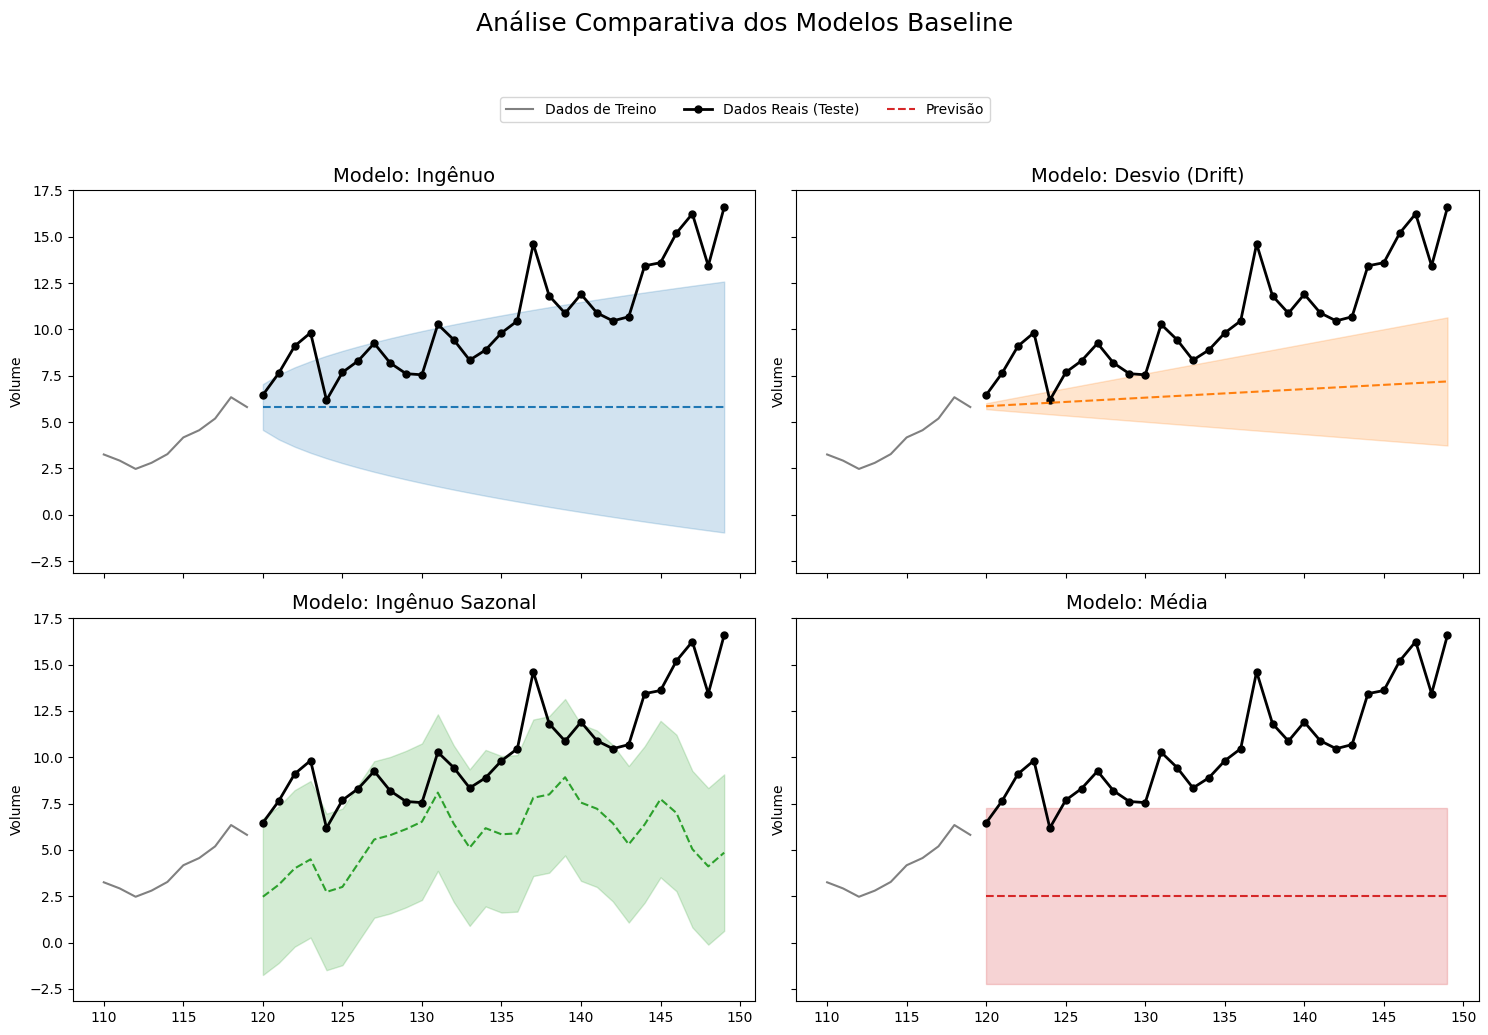

In [19]:
n_models = len(predictions)
fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharex=True, sharey=True)

# Define a paleta de cores
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'] # Azul, Laranja, Verde, Vermelho

# << ALTERAÇÃO AQUI: Define a ordem de plotagem desejada
plot_order = ['Ingênuo', 'Desvio (Drift)', 'Ingênuo Sazonal', 'Média']

for i, name in enumerate(plot_order):
    ax = axes.flatten()[i] 
    color = colors[i % len(colors)]
    
    # Plota os dados base
    ax.plot(train.iloc[-10:], label='Dados de Treino', color='gray')
    ax.plot(test, label='Dados Reais (Teste)', color='black', linewidth=2, marker='o', markersize=5)
    
    # Previsão e intervalo com a cor específica
    forecast_to_plot = predictions[name]
    interval_to_plot = intervals[name]
    ax.plot(forecast_to_plot, label=f'Previsão', linestyle='--', color=color)
    
    # Plota o intervalo de previsão sombreado
    ax.fill_between(
        interval_to_plot['lower'].index,
        interval_to_plot['lower'],
        interval_to_plot['upper'],
        alpha=0.2,
        color=color
    )
    
    # Configurações do gráfico individual
    ax.set_title(f'Modelo: {name}', fontsize=14)
    ax.set_ylabel('Volume')
    ax.grid(False)

# Configurações gerais do painel de gráficos
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=4)
fig.suptitle('Análise Comparativa dos Modelos Baseline', fontsize=18, y=1.03)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

# Regressão Linear Múltipla com Covariáveis

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
)
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import norm

# Configurações para os gráficos
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 7)

## Definindo as covariáveis

Iremos utilizar a covariável básica de trend, em conjunto com a indicadora mensal, e por fim, adicionar os lags de 1, 4 e 12 semanas, além disso, também iremos incluir as médias móveis e médias móveis exponencias de 4 e 12 semanas, e por fim, a volatilidade de 4 e 12 semanas.

Visto que a série temporal não apresenta sazonalidade anual, não iremos adicionar variáveis muito distantes no tempo.

In [21]:
# Carregando os dados originais
data = pd.read_csv("data.csv")
data["week"] = pd.to_datetime(data["week"])
data_series = data.set_index("week")['volume']

# --- Definição de Atributos ---
df = pd.DataFrame({'volume': data_series})
df['trend'] = range(len(df))

# Dummies mensais
df['month'] = df.index.month
df = pd.get_dummies(df, columns=['month'], drop_first=True, prefix='mes')
dummy_cols = [col for col in df.columns if 'mes_' in col]
df[dummy_cols] = df[dummy_cols].astype(int)

# Lags
df['lag_1'] = df['volume'].shift(1)
df['lag_4'] = df['volume'].shift(4)
df['lag_12'] = df['volume'].shift(12)

# Médias Móveis (Simples e Exponencial)
df['volume_sma_4'] = df['volume'].rolling(window=4).mean().shift(1)
df['volume_sma_12'] = df['volume'].rolling(window=12).mean().shift(1)
df['volume_ema_4'] = df['volume'].ewm(span=4, adjust=False).mean().shift(1)
df['volume_ema_12'] = df['volume'].ewm(span=12, adjust=False).mean().shift(1)

# Desvio Padrão Móvel
df['volume_std_4'] = df['volume'].rolling(window=4).std().shift(1)
df['volume_std_12'] = df['volume'].rolling(window=12).std().shift(1)

df.dropna(inplace=True)

X = df.drop('volume', axis=1)
y = df['volume']

Definindo o conjunto de treinamento e teste:

In [22]:
# Divisão cronológica dos dados
train_size_full = len(data_series)
train_size_adjusted = int(train_size_full * 0.8) - 12

X_train, X_test = X.iloc[:train_size_adjusted], X.iloc[train_size_adjusted:]
y_train, y_test = y.iloc[:train_size_adjusted], y.iloc[train_size_adjusted:]

train_volume = data_series.iloc[: int(train_size_full * 0.8)]
test_volume = data_series.iloc[int(train_size_full * 0.8) :]

## Gerando as predições dos modelos

Considerando as covariáveis como grupos, para ver o desempenho de cada grupo de variáveis.

In [23]:
predictions = {}
models = {}

months_cols = [col for col in X.columns if 'mes_' in col]
lag_cols = ['lag_1', 'lag_4', 'lag_12']
ma_cols = ['volume_sma_4', 'volume_sma_12', 'volume_ema_4', 'volume_ema_12']
std_cols = ['volume_std_4', 'volume_std_12']

models_cols = {
    'Tendência': ['trend'],
    'Meses': months_cols,
    'Lags': lag_cols,
    'Médias Móveis': ma_cols,
    'Desvio Padrão Móvel': std_cols,
}

for model_name, cols in models_cols.items():
    X_train_model = sm.add_constant(X_train[cols])
    X_test_model = sm.add_constant(X_test[cols])

    model = sm.OLS(y_train, X_train_model).fit()
    models[model_name] = model

    y_pred = model.predict(X_test_model)
    predictions[model_name] = y_pred

In [24]:
# Função para o Winkler Score
def winkler_score(y_true, lower, upper, alpha):
    score = np.where(
        y_true < lower,
        (upper - lower) + (2 / alpha) * (lower - y_true),
        np.where(
            y_true > upper,
            (upper - lower) + (2 / alpha) * (y_true - upper),
            (upper - lower),
        ),
    )
    return np.mean(score)


# Função para o Erro de Quantil
def quantile_score(y_true, quantile_forecast, p):
    error = y_true - quantile_forecast
    return np.mean(np.where(error >= 0, p * error, (p - 1) * error))


# Função para o CRPS de uma distribuição Normal
def crps_gaussian(y_true, mu, sigma):
    z = (y_true - mu) / sigma
    crps = sigma * (
        z * (2 * norm.cdf(z) - 1) + 2 * norm.pdf(z) - 1 / np.sqrt(np.pi)
    )
    return np.mean(crps)

## Analisando as métricas das predições dos grupos

In [25]:
intervals = {}
residuals_std = {}


def update_and_get_metrics(
    models, predictions, results_list, train_volume, test_volume, alpha=0.05
):
    processed_models = [res['Modelo'] for res in results_list]

    new_model_names = [
        name for name in models.keys() if name not in processed_models
    ]

    if not new_model_names:
        return pd.DataFrame(results_list).set_index('Modelo')

    for name in new_model_names:
        residuals_std[name] = models[name].resid.std()

    for name in new_model_names:
        forecast = predictions[name]
        sigma = residuals_std[name]
        z_score = norm.ppf(1 - alpha / 2)
        intervals[name] = {
            'lower': forecast - z_score * sigma,
            'upper': forecast + z_score * sigma,
        }

    # --- Cálculo das Métricas ---
    m = 12  # Sazonalidade para o scale do MASE
    scale = np.mean(np.abs(train_volume.diff(m).dropna()))
    quantiles_to_check = [0.1, 0.25, 0.5, 0.75, 0.9]

    for name in new_model_names:
        forecast = predictions[name]
        current_test_volume = test_volume[forecast.index]
        interval = intervals[name]
        sigma = residuals_std[name]

        # Métricas de erro pontual
        mae = mean_absolute_error(current_test_volume, forecast)
        rmse = np.sqrt(mean_squared_error(current_test_volume, forecast))
        mape = mean_absolute_percentage_error(current_test_volume, forecast)
        mase = mae / scale

        # Métricas probabilísticas
        winkler = winkler_score(
            current_test_volume, interval['lower'], interval['upper'], alpha
        )
        sigma_h = pd.Series(sigma, index=current_test_volume.index)
        crps = crps_gaussian(current_test_volume, forecast, sigma_h)

        # Métrica de quantil
        avg_quantile_loss = []
        for p in quantiles_to_check:
            quantile_forecast = norm.ppf(p, loc=forecast, scale=sigma_h)
            avg_quantile_loss.append(
                quantile_score(current_test_volume, quantile_forecast, p)
            )

        # Adiciona os resultados à lista
        results_list.append(
            {
                'Modelo': name,
                'MAE': mae,
                'RMSE': rmse,
                'MAPE (%)': mape * 100,
                'MASE': mase,
                'Winkler Score': winkler,
                'Avg Quantile Score': np.mean(avg_quantile_loss),
                'CRPS': crps,
            }
        )

    return pd.DataFrame(results_list).set_index('Modelo')


results_list = []

results_df = update_and_get_metrics(
    models, predictions, results_list, train_volume, test_volume
)

print("\n--- Tabela Comparativa de Métricas (Grupos de Covariáveis) ---")
results_df.round(4).sort_values(by='RMSE')


--- Tabela Comparativa de Métricas (Grupos de Covariáveis) ---


,MAE,RMSE,MAPE (%),MASE,Winkler Score,Avg Quantile Score,CRPS
Modelo,,,,,,,
Médias Móveis,1.3680,1.7275,13.1918,1.0057,19.9436,0.5458,1.0940
Lags,1.3731,1.7571,12.9775,1.0095,22.2627,0.5457,1.0980
Desvio Padrão Móvel,3.7363,4.4954,33.7427,2.7467,78.0712,1.5835,3.1663
Tendência,3.8318,4.5048,33.2286,2.8169,53.7312,1.5146,3.0359
Meses,7.2768,7.7198,68.1374,5.3495,120.3251,3.0051,5.9801


Pelos resultados podemos observar que o modelo de médias móveis apresentou o melhor desempenho, seguido do modelo com lags, que performaram bem melhores do que o modelo básico com trend e volatiliade, e o modelo de indicadoras mensais foi o pior de todos.

## Analisando os parâmetros dos melhores modelos

In [26]:
models["Médias Móveis"].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 volume   R-squared:                       0.927
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                     328.9
Date:                Wed, 01 Oct 2025   Prob (F-statistic):           1.07e-57
Time:                        18:45:10   Log-Likelihood:                -107.90
No. Observations:                 108   AIC:                             225.8
Df Residuals:                     103   BIC:                             239.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1341      0.102      1.316      0.191      -0.068       0.336
volume_sma_4     -1.3314      0.364     -3.660      0.000      -2.053      -0.610
volume_sma_12    -0.7518      0.430     -1.747      0.084      -1.605       0.102
volume_ema_4      2.6379      0.386      6.838      0.000       1.873       3.403
volume_ema_12     0.4198      0.540      0.777      0.439      -0.651       1.491
==============================================================================
Omnibus:                        7.729   Durbin-Watson:                   1.579
Prob(Omnibus):                  0.021   Jarque-Bera (JB):               14.378
Skew:                          -0.130   Prob(JB):                     0.000755
Kurtosis:                       4.769   Cond. No.                         75.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [27]:
models["Lags"].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 volume   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     510.7
Date:                Wed, 01 Oct 2025   Prob (F-statistic):           4.63e-62
Time:                        18:45:10   Log-Likelihood:                -100.72
No. Observations:                 108   AIC:                             209.4
Df Residuals:                     104   BIC:                             220.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1568      0.091      1.717      0.089      -0.024       0.338
lag_1          0.8982      0.057     15.719      0.000       0.785       1.011
lag_4          0.1660      0.072      2.321      0.022       0.024       0.308
lag_12        -0.1091      0.044     -2.505      0.014      -0.195      -0.023
==============================================================================
Omnibus:                        5.943   Durbin-Watson:                   1.794
Prob(Omnibus):                  0.051   Jarque-Bera (JB):                9.322
Skew:                          -0.079   Prob(JB):                      0.00946
Kurtosis:                       4.431   Cond. No.                         9.47
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Vemos um problema no modelo de médias móveis, onde o parâmetro volume_ema_12 tem um p-valor alto, e seu intervalo de confiança inclui o zero, indicando que esse parâmetro não é estatisticamente significativo.

Levando isso em consideração, criaremos novos modelos removendo esse parâmetro e juntando mais grupos de variáveis para analisar o desempenho.

In [28]:
ma_cols.remove("volume_ema_12")

models_combined_cols = {
    "Médias Móveis (Simplificada)": ma_cols,
    "Lags + Médias Móveis": lag_cols + ma_cols,
    "Lags + Médias Móveis + Tendência": lag_cols + ma_cols + ['trend'],
    "Lags + Médias Móveis + Desvio Padrão": lag_cols + ma_cols + std_cols,
}

for model_name, cols in models_combined_cols.items():
    X_train_model = sm.add_constant(X_train[cols])
    X_test_model = sm.add_constant(X_test[cols])

    model = sm.OLS(y_train, X_train_model).fit()
    models[model_name] = model

    y_pred = model.predict(X_test_model)
    predictions[model_name] = y_pred

In [29]:
results_df = update_and_get_metrics(models, predictions, results_list, train_volume, test_volume)

print("\n--- Tabela Comparativa de Métricas Atualizada (Modelos Combinados) ---")
results_df.round(4).sort_values(by='RMSE')


--- Tabela Comparativa de Métricas Atualizada (Modelos Combinados) ---


,MAE,RMSE,MAPE (%),MASE,Winkler Score,Avg Quantile Score,CRPS
Modelo,,,,,,,
Médias Móveis,1.3680,1.7275,13.1918,1.0057,19.9436,0.5458,1.0940
Médias Móveis (Simplificada),1.3870,1.7325,13.4134,1.0197,19.7772,0.5536,1.1106
Lags,1.3731,1.7571,12.9775,1.0095,22.2627,0.5457,1.0980
Lags + Médias Móveis,1.4475,1.8576,13.8147,1.0642,25.0619,0.5993,1.1969
Lags + Médias Móveis + Tendência,1.4439,1.8770,13.6818,1.0615,25.7232,0.5964,1.1915
Lags + Médias Móveis + Desvio Padrão,1.5293,2.0021,14.4195,1.1243,28.6114,0.6384,1.2755
Desvio Padrão Móvel,3.7363,4.4954,33.7427,2.7467,78.0712,1.5835,3.1663
Tendência,3.8318,4.5048,33.2286,2.8169,53.7312,1.5146,3.0359
Meses,7.2768,7.7198,68.1374,5.3495,120.3251,3.0051,5.9801


Analisando os grupos de modelos é visível que, nenhum grupo performou melhor do que o modelo de médias móveis, considerando o modelo mais simples, das médias.

In [30]:
models["Médias Móveis (Simplificada)"].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 volume   R-squared:                       0.927
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                     440.0
Date:                Wed, 01 Oct 2025   Prob (F-statistic):           6.31e-59
Time:                        18:45:10   Log-Likelihood:                -108.22
No. Observations:                 108   AIC:                             224.4
Df Residuals:                     104   BIC:                             235.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1576      0.097      1.622      0.108      -0.035       0.350
volume_sma_4     -1.3445      0.363     -3.707      0.000      -2.064      -0.625
volume_sma_12    -0.4258      0.097     -4.399      0.000      -0.618      -0.234
volume_ema_4      2.7309      0.366      7.461      0.000       2.005       3.457
==============================================================================
Omnibus:                        7.618   Durbin-Watson:                   1.560
Prob(Omnibus):                  0.022   Jarque-Bera (JB):               13.943
Skew:                          -0.134   Prob(JB):                     0.000938
Kurtosis:                       4.740   Cond. No.                         47.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Temos como resultado um modelo quase infimamente pior, mas com parâmetros significativos.

## Visualizando resultados

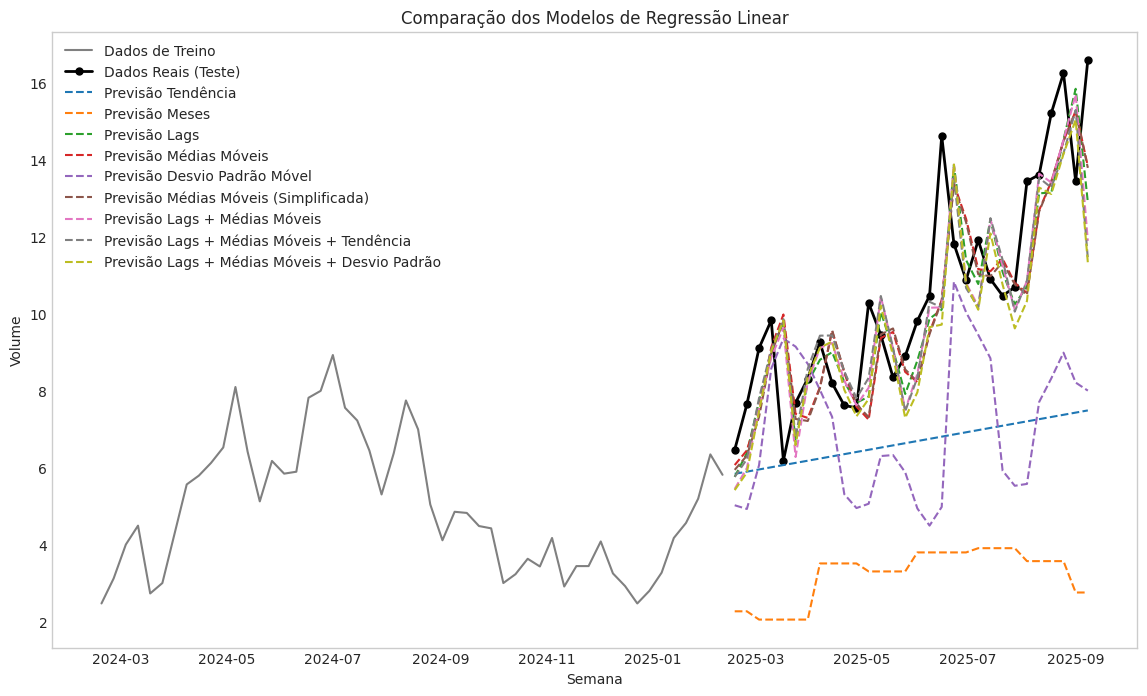

In [31]:
# Visualização e Avaliação Final

plt.figure(figsize=(14, 8))
plt.plot(y_train.iloc[-52:], label='Dados de Treino', color='gray')

plt.plot(
    y_test,
    label='Dados Reais (Teste)',
    color='black',
    linewidth=2,
    marker='o',
    markersize=5,
)

for name, forecast in predictions.items():
    plt.plot(forecast, label=f'Previsão {name}', linestyle='--')

plt.title('Comparação dos Modelos de Regressão Linear')
plt.xlabel('Semana')
plt.ylabel('Volume')
plt.legend(loc='upper left')
plt.grid(False)

plt.show()

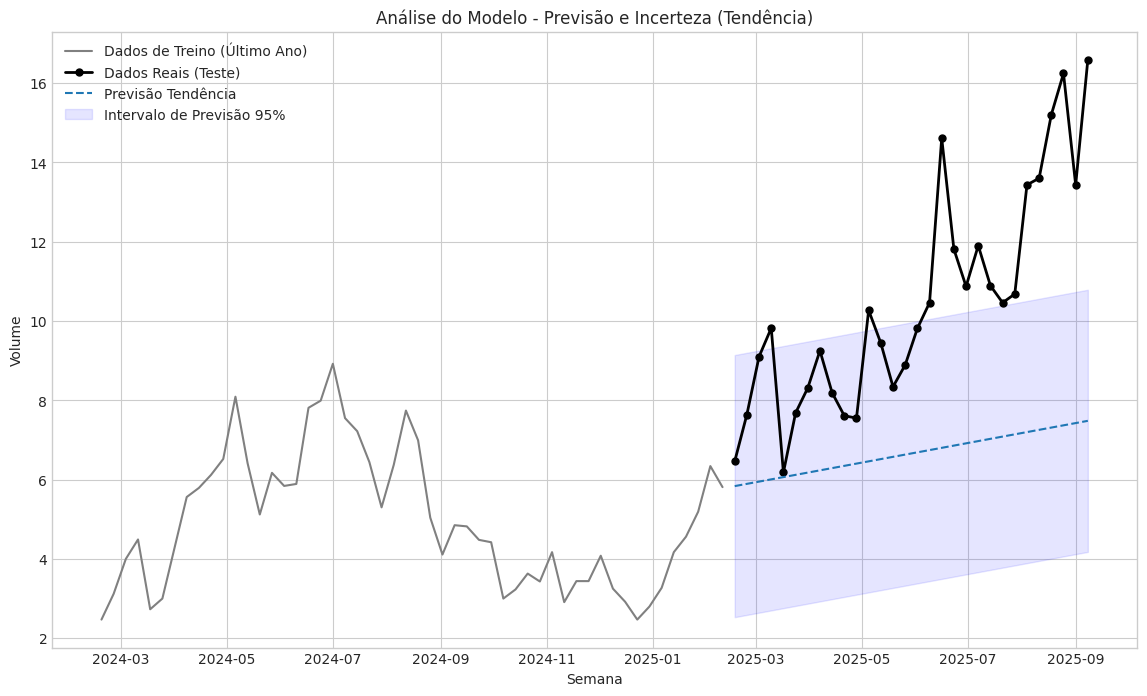

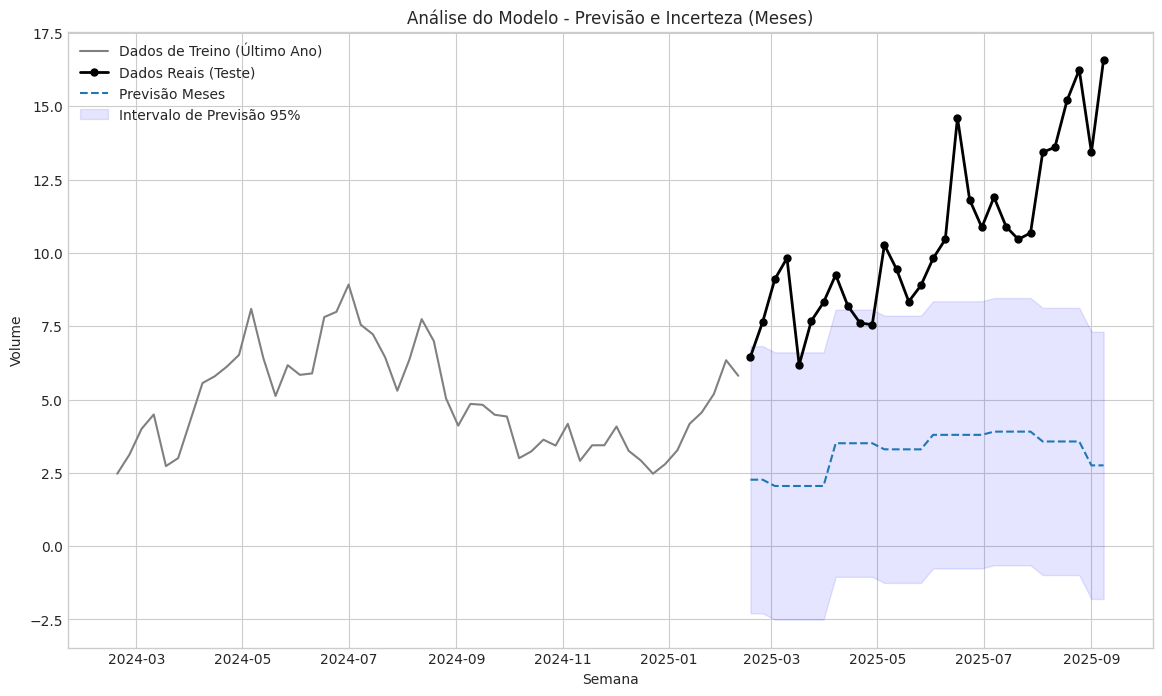

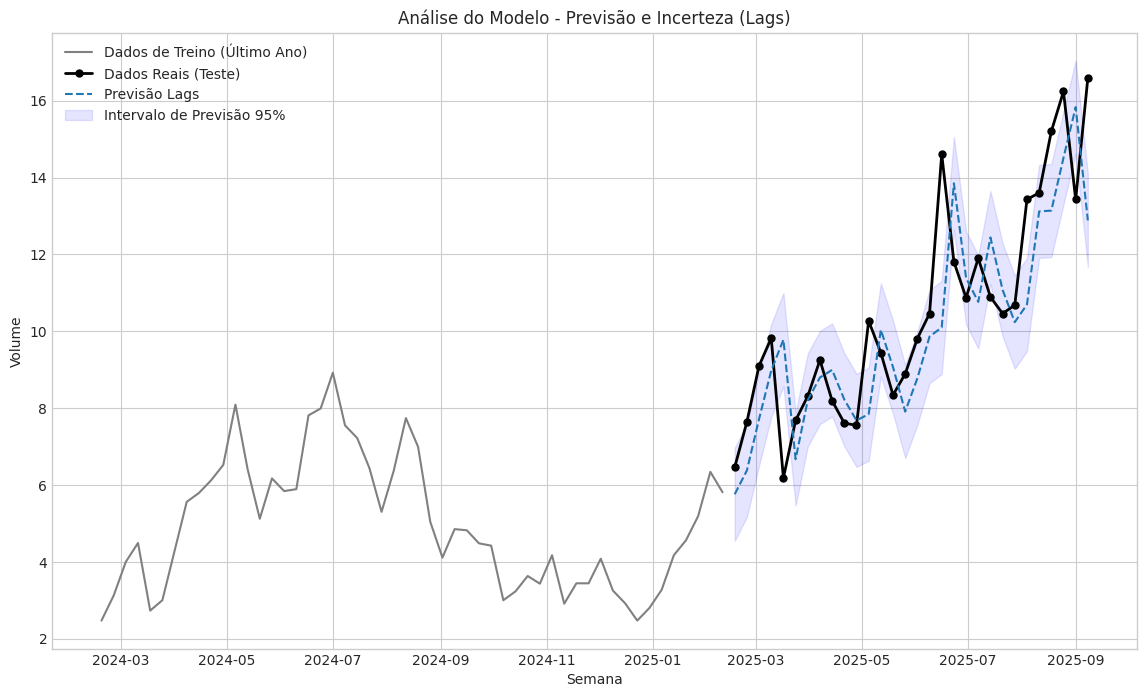

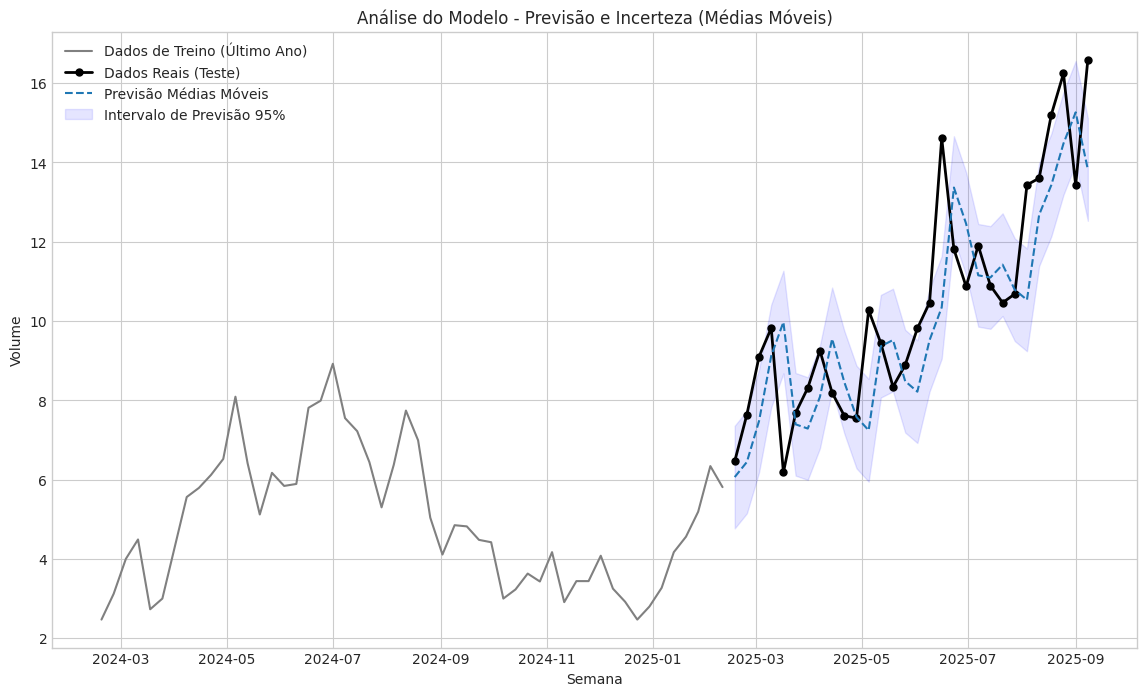

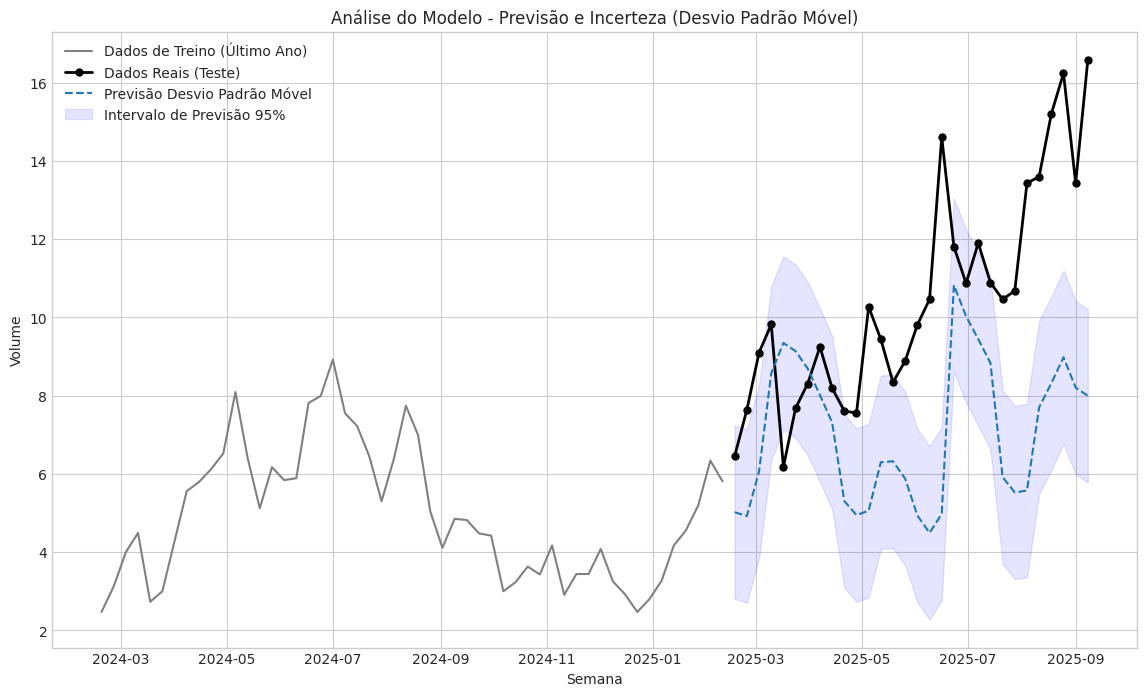

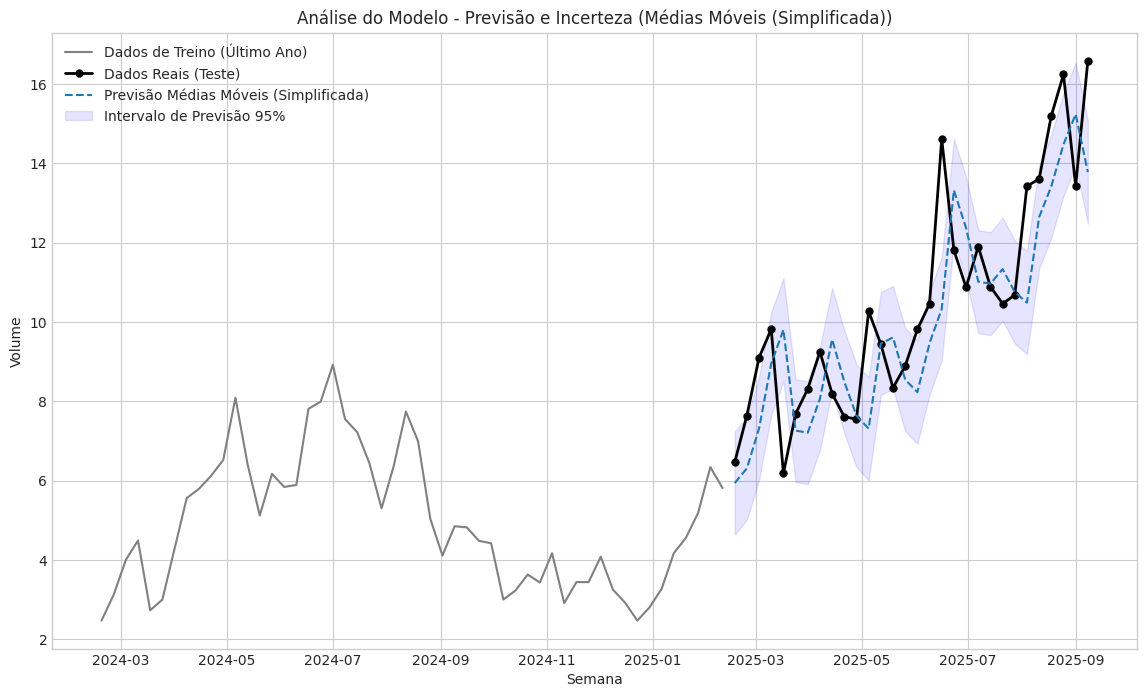

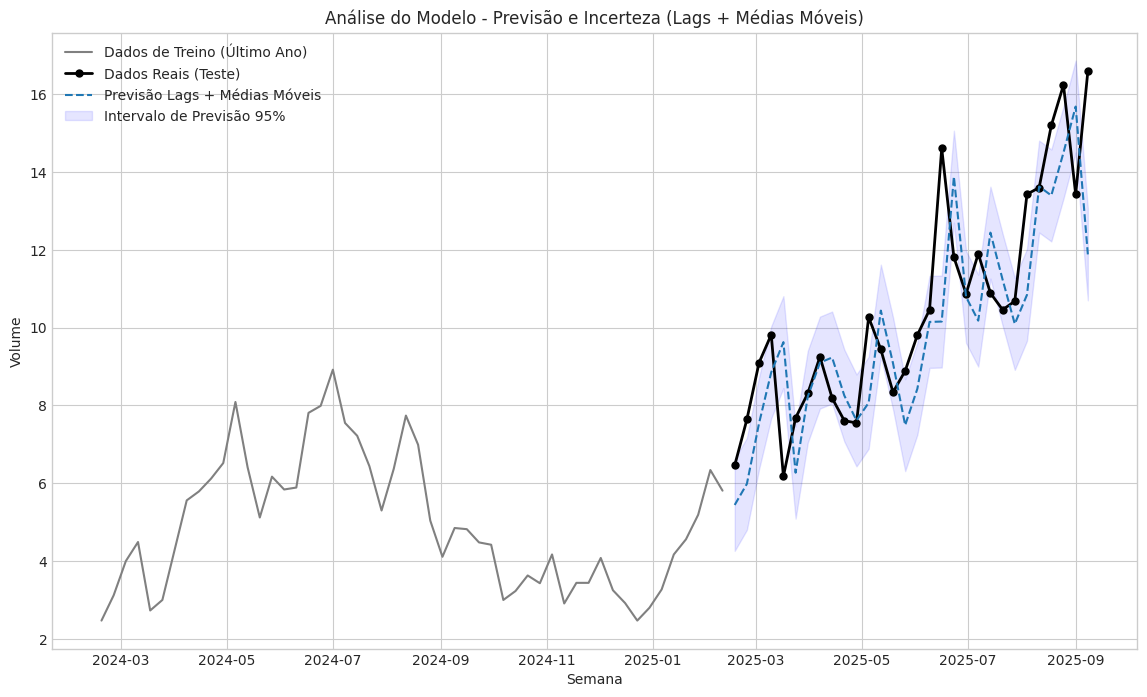

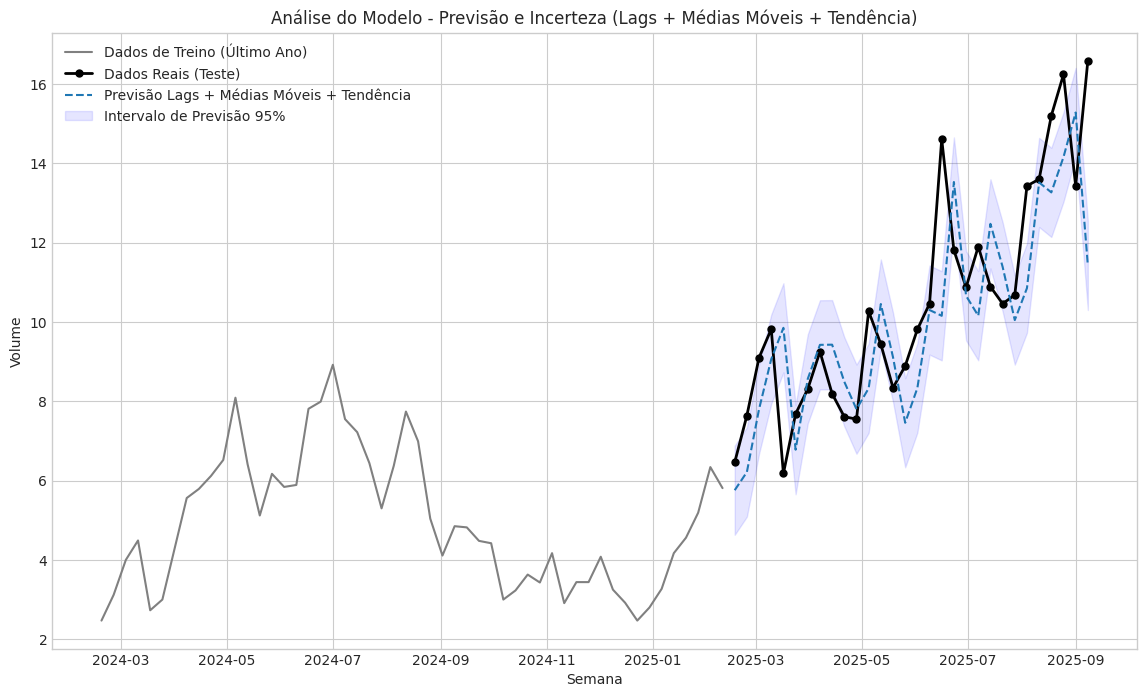

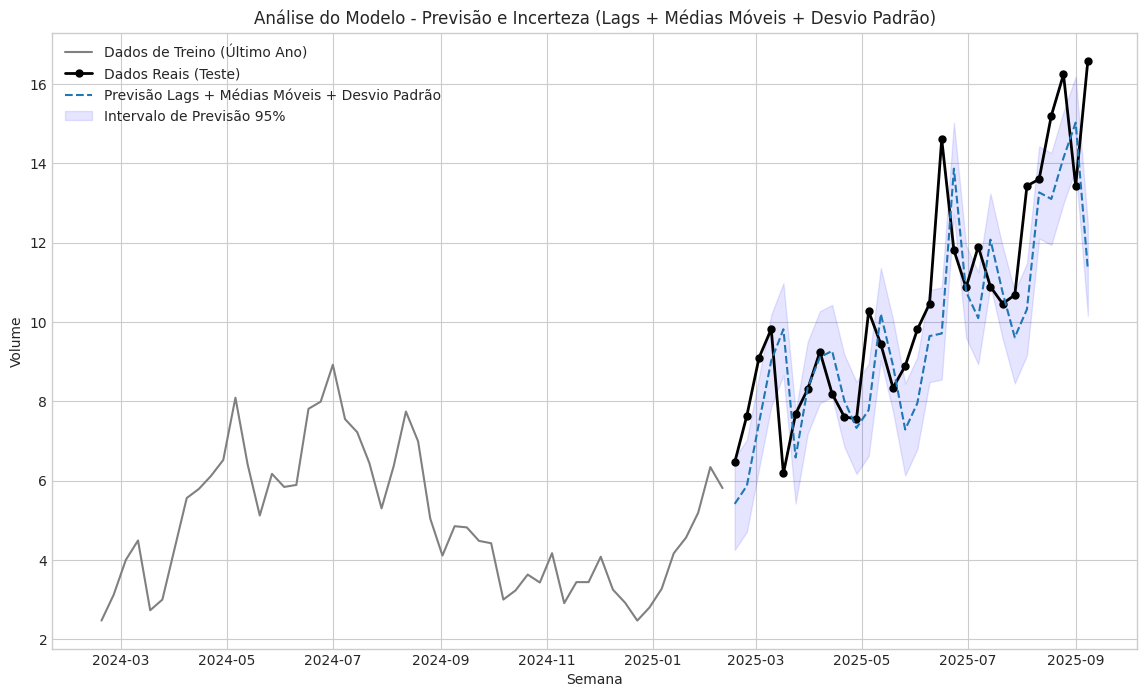

In [32]:
model_names = models.keys()

for name in model_names:
    plt.figure(figsize=(14, 8))

    plt.plot(
        y_train.iloc[-52:], label='Dados de Treino (Último Ano)', color='gray'
    )
    plt.plot(
        y_test,
        label='Dados Reais (Teste)',
        color='black',
        linewidth=2,
        marker='o',
        markersize=5,
    )

    forecast_to_plot = predictions[name]
    interval_to_plot = intervals[name]

    plt.plot(forecast_to_plot, label=f'Previsão {name}', linestyle='--')

    plt.fill_between(
        interval_to_plot['lower'].index,
        interval_to_plot['lower'],
        interval_to_plot['upper'],
        color='blue',
        alpha=0.1,
        label='Intervalo de Previsão 95%',
    )

    plt.title(f'Análise do Modelo - Previsão e Incerteza ({name})')
    plt.xlabel('Semana')
    plt.ylabel('Volume')
    plt.legend(loc='upper left')
    plt.grid(True)

    plt.show()

Por fim, visualizamos os resultados dos modelos, que apresentaram um desempenho muito bom. Além disso, os modelos de médias móveis e lags conseguiram capturar a maioria dos padrões da série temporal.